### Speed of NYC Permit Approval for Green Retrofits of Small Buildings
#### Data Exploration

Setup

In [63]:
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
import geopandas as gpd

Define Socrata API handler to page through JSON data

In [3]:
def get_resource(resource, query='', dates=[], limit=1000, progress=False):
    headers = {'X-App-Token': 'b0nu5h6f5RSJRNPajPuuCf7wo'}
    result = []
    offset = 0
    while offset >= 0:
        url = f'https://data.cityofnewyork.us/resource/{resource}.json?$limit={limit}&$offset={offset}&$order=:id'
        if query != '': #can't use requests params bc of possible $ char
            url += f'&{query}'
        if (progress):
            print(url)
        json = requests.get(url, headers=headers).json()
        if 'error' in json:
            print(json['message'])
            return
        else:
            df = pd.DataFrame(json)
            if len(df):
                if len(dates):
                    df[dates] = df[dates].apply(pd.to_datetime, errors='coerce')
                result.append(df)
                offset += limit
            else:
                offset = -1

    result = pd.concat(result).reset_index() if len(result) else pd.DataFrame()
    print(f'Retreived {len(result)} records')
    return result

Get [job application](https://data.cityofnewyork.us/Housing-Development/DOB-Job-Application-Filings/ic3t-wcy2?category=Housing-Development&view_name=DOB-Job-Application-Filings) A2-3 filings (non occupancy/egress alterations)

In [4]:
resource = 'ic3t-wcy2'
query = "$where=job_type IN ('A2', 'A3') AND job_status IN ('P', 'Q', 'R') AND job_description != ''"
dates = ['latest_action_date', 'assigned', 'approved', 'fully_permitted']
job = get_resource(resource, query, dates)

Retreived 475212 records


In [5]:
job.to_feather('job.feather')

Exploratory analysis

In [19]:
job = job[job['job_description'].notnull()].copy()
job['is_green'] = job['job_description'].str.match('.+solar.+', case=False)
job['is_green'].value_counts()

False    453785
True       9804
Name: is_green, dtype: int64

In [20]:
_ = [print(desc) for desc in job.loc[job['is_green'], 'job_description'][:10]]

ROOFTOP SOLAR PANEL INSTALLATION
INSTALLATION OF SOLAR SYSTEM AS PER PLANS.NO CHANGE IN USE,EGRESS, OR OCCUPANCY
INSTALLATION OF SOLAR ENERGY SYSTEM ON ROOF. NO CHANGE OF OCCUPANCY, USE OR EGRESS.
8.910KW ROOF MOUNTED SOLAR PV ARRAY
FILING HEREWITH TAX ABATEMENT APPLICATION FOR INSTALLATION OF ROOF MOUNTED SOLAR PANELS.  NO CHANGE IN USE, EGRESS OR OCCUPANCY.
INSTALLATION OF SOLAR PANELS ON ROOF. NO CHANGE IN USE, EGRESS, OR OCCUPANCY.
THIS IS A SOLAR PTA4 ROOF MOUNTED SYSTEM
INSTALLATION OF SOLAR PANELS ON EXISTING ROOF STRUCTURE. NO CHANGE IN EGRESS, USE, OR OCCUPANCY
INSTALLATION OF SOLAR SYSTEM AS PER PLANS. NO CHANGE IN USE, EGRESS, OR OCCUPANCY
INSTALLATION OF SOLAR PANELS ON EXISTING ROOF. NO CHANGE IN USE, OCCUPANCY,  OR EGRESS. NO CHANGE IN BULK.


In [59]:
job['approval_days'] = (job['approved'] - job['assigned']).dt.days

<AxesSubplot:ylabel='Density'>

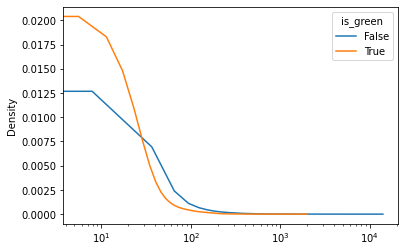

In [62]:
job.pivot(columns='is_green', values='approval_days').plot.density(logx=True)

In [91]:
cols = ['gis_latitude', 'gis_longitude']
job[cols] = job[cols].apply(pd.to_numeric, errors='coerce')
job['approved_year'] = job['approved'].dt.year

green = job[job['is_green']].dropna(subset=cols)
green['points'] = gpd.points_from_xy(green['gis_longitude'], green['gis_latitude'])
green = gpd.GeoDataFrame(green, geometry='points').set_crs('EPSG:4326')

In [86]:
zips = gpd.read_file('ZIP_CODE_040114').to_crs('EPSG:4326')

<AxesSubplot:>

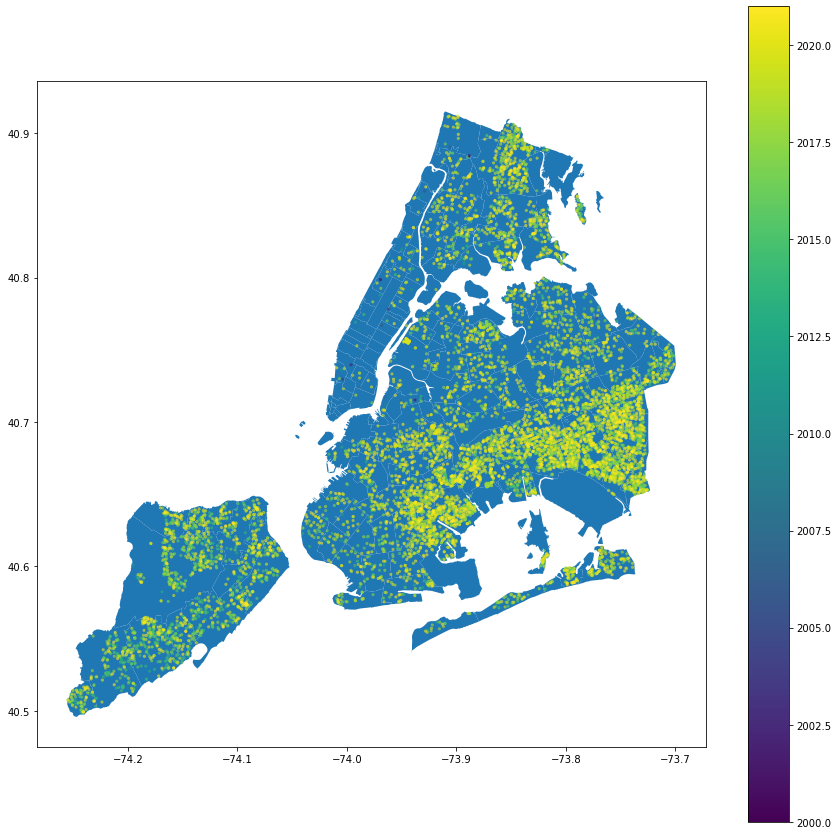

In [96]:
fig, ax = plt.subplots(figsize=(15, 15))
zips.plot(ax=ax)
green.plot(column='approved_year', ax=ax, legend=True, alpha=.5, markersize=5)

Use building characteristics (age, roof size, svf), demographics, real-estate data?, neighbors/social to predict likelihood of a building getting rooftop solar